In [1]:
#GPU 사용 가능한지 체크
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import keras.backend as K
import numpy as np


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations

In [3]:
from keras.layers import Input, Dense, LSTM ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model

#from attention_utils import get_activations
#from keras.layers import merge
from keras.layers import Multiply
from keras.layers.core import *
#from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset, look_back):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

# Multidimensional normalization returns data and maximum and minimum values
def NormalizeMult(data):
    #normalize Used for denormalization
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    for i in range(0,data.shape[1]):
        #Column i
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

# Multidimensional denormalization
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data


def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.1)(x)
    x2 = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(x)  #, padding = 'same'
    x2 = Dropout(0.1)(x2)
    
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out2 = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_out)
    lstm_out2 = Dropout(0.3)(lstm_out2)
    attention_mul = attention_3d_block(lstm_out2)
    attention_mul = Flatten()(attention_mul)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [4]:
from sklearn.model_selection import train_test_split
df=pd.DataFrame(pd.read_excel('./F5_데이터정리.xlsx', sheet_name='Daily')['mkt_exr'])
train_size = int(len(df)*0.8)
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]
#train, test = train_test_split(df, test_size=0.1)
print("len(train):",len(train))
print("len(test):",len(test))

len(train): 4652
len(test): 1164


In [5]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficiaent of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model.h5'
# TRAIN
INPUT_DIMS = 1
TIME_STEPS = 100
lstm_units = 64

#Normalized
train,normalize = NormalizeMult(train)
#train=np.array(train)
pollution_data = train[:,0].reshape(len(train),1)

train_X, _ = create_dataset(train,TIME_STEPS)
_ , train_Y = create_dataset(pollution_data,TIME_STEPS)
print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
#m.compile(optimizer='adam', loss='mse')
m.compile(loss='mse', optimizer='adam',metrics=['mse',r2_keras])

# fit the network
history =  m.fit([train_X], train_Y, epochs=20, batch_size=64, validation_split=0.25)
#history = m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                       ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#          )

(4551, 100, 1) (4551, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 64)      128         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 100, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 128)     66048       ['dropout[0][0]']                
                                                                     

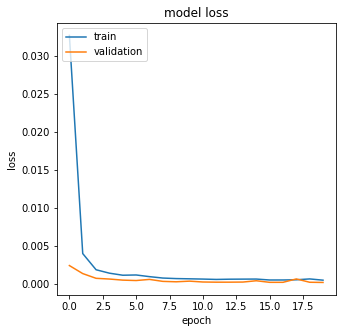

In [7]:
import matplotlib.pyplot as plt

# summarize history for Loss
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
# TEST
test,normalize = NormalizeMult(test)
#test=np.array(test)
pollution_test = test[:,0].reshape(len(test),1)

test_X, _ = create_dataset(test,TIME_STEPS)
_ , test_Y = create_dataset(pollution_test,TIME_STEPS)
print(test_X.shape,test_Y.shape)

(1063, 100, 1) (1063, 1)


In [9]:
# Prediction
scores_test = m.evaluate([test_X], test_Y, verbose=2)

34/34 - 1s - loss: 0.0012 - mse: 0.0012 - r2_keras: 0.2523 - 1s/epoch - 34ms/step


In [10]:
results = m.predict([test_X])

34/34 [==============================] - 1s 23ms/step


In [11]:
results

array([[0.11199982],
       [0.11332829],
       [0.11578133],
       ...,
       [0.6037238 ],
       [0.617087  ],
       [0.625536  ]], dtype=float32)

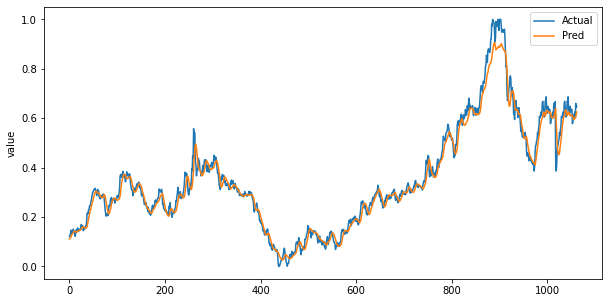

In [12]:
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(test_Y)
plt.plot(results)
plt.ylabel('value')
plt.legend(['Actual', 'Pred'])
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error

def confirm_result(y_test, y_pred):
  
  RMSE = mean_squared_error(y_test, y_pred)**0.5
  return np.round(RMSE,4)

#print('Train RMSE: ', confirm_result(train_set_output, train_predictions.reshape(-1,1)))
print('Test RMSE: ', confirm_result(test_Y, results.reshape(-1,1)))

Test RMSE:  0.0341
